In [ ]:
import requests
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
API_URL = "https://api.open-meteo.com/v1/forecast?latitude=39.9199&longitude=32.8543&hourly=temperature_2m,apparent_temperature,relative_humidity_2m,dew_point_2m,wind_speed_10m&timezone=Europe%2FIstanbul"

In [ ]:
def fetch_weather_data(url):
    """Verilen Open-Meteo API URL'sinden veriyi çeker."""
    try:
        print("API'den veri çekiliyor...")
        response = requests.get(url)
        response.raise_for_status() # Hata durumunda istisna fırlat
        data = response.json()
        return data['hourly']
    except requests.exceptions.RequestException as e:
        print(f"API isteği sırasında hata oluştu: {e}")
        return None

In [ ]:
def prepare_data(hourly_data):
    """Çekilen saatlik veriyi Pandas DataFrame'e dönüştürür ve temizler."""
    if not hourly_data:
        return None, None

    # Veriyi DataFrame'e yükle
    df = pd.DataFrame(hourly_data)

    # NaN (Eksik) değerleri, basitleştirme adına ortalama ile dolduralım
    df = df.fillna(df.mean(numeric_only=True))

    # X: Öznitelikler (Features)
    # y: Hedef (Target)
    X = df[['temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'wind_speed_10m']]
    y = df['apparent_temperature']

    # Sütun adlarını daha kısa ve anlaşılır hale getirelim
    X.columns = ['Temp', 'Humidity', 'Dewpoint', 'WindSpeed']

    return X, y

In [ ]:
if __name__ == "__main__":
    hourly_data = fetch_weather_data(API_URL)

    if hourly_data and len(hourly_data['time']) > 0:
        print(f"Veri başarıyla çekildi. Toplam {len(hourly_data['time'])} saatlik kayıt var.")

        # Veriyi hazırla
        X, y = prepare_data(hourly_data)

        if X is not None and len(X) > 10: # Yeterli veri kontrolü
            # Veriyi Bölme (%80 Eğitim, %20 Test)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Random Forest Modelini Eğitme
            model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
            model.fit(X_train, y_train)

            # Tahmin ve Değerlendirme
            y_pred = model.predict(X_test)

            # Metrikler
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            print("\n--- Model Performansı (Görünür Sıcaklık Tahmini) ---")
            print(f"Eğitim Verisi Boyutu: {len(X_train)}")
            print(f"Test Verisi Boyutu: {len(X_test)}")
            print("-" * 50)
            print(f"Kök Ortalama Kare Hatası (RMSE): {rmse:.3f} °C")
            print(f"R-Kare Skoru (R²): {r2:.4f}")
            print("-" * 50)

            # Öznitelik Önemini Gösterme
            feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
            print("Öznitelik Önem Sıralaması:")
            print(feature_importances)

            # Örnek Tahmin
            sample_data = X_test.iloc[[0]]
            predicted_temp = model.predict(sample_data)[0]
            actual_temp = y_test.iloc[0]

            print(f"\nİlk Test Kaydı İçin Gerçek Sıcaklık: {actual_temp:.2f} °C")
            print(f"İlk Test Kaydı İçin Tahmin Edilen Sıcaklık: {predicted_temp:.2f} °C")

        else:
            print("Yeterli sayıda veri kaydı bulunamadı (API'den çekilen verinin yapısını kontrol edin).")
    else:
        print("Veri çekilemedi veya boş geldi.")

API'den veri çekiliyor...
Veri başarıyla çekildi. Toplam 168 saatlik kayıt var.
Veri Hazırlandı ve Öznitelikler Belirlendi.
Random Forest Modeli Eğitiliyor...

--- Model Performansı (Görünür Sıcaklık Tahmini) ---
Eğitim Verisi Boyutu: 134
Test Verisi Boyutu: 34
--------------------------------------------------
Kök Ortalama Kare Hatası (RMSE): 0.404 °C
R-Kare Skoru (R²): 0.9948
--------------------------------------------------
Öznitelik Önem Sıralaması:
Temp         0.992760
Dewpoint     0.004186
WindSpeed    0.002303
Humidity     0.000751
dtype: float64

İlk Test Kaydı İçin Gerçek Sıcaklık: 14.10 °C
İlk Test Kaydı İçin Tahmin Edilen Sıcaklık: 13.71 °C


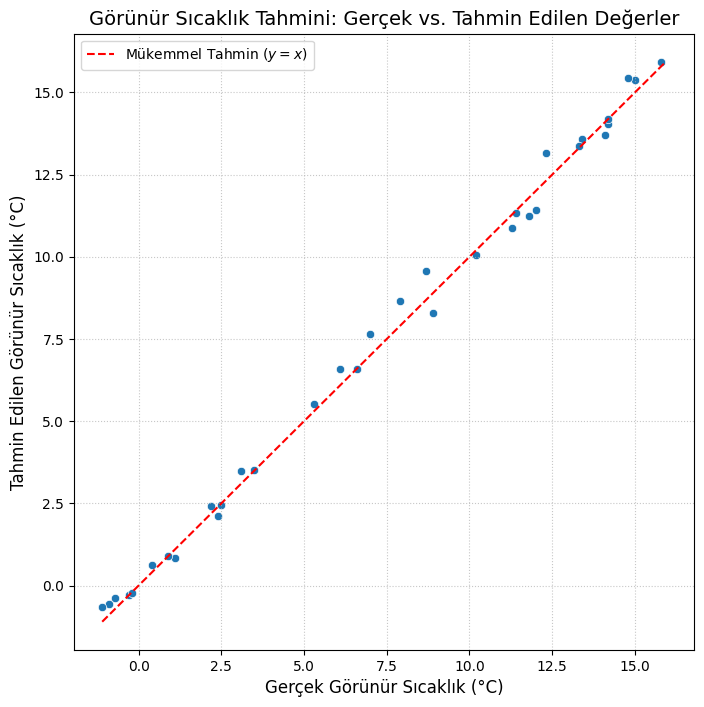

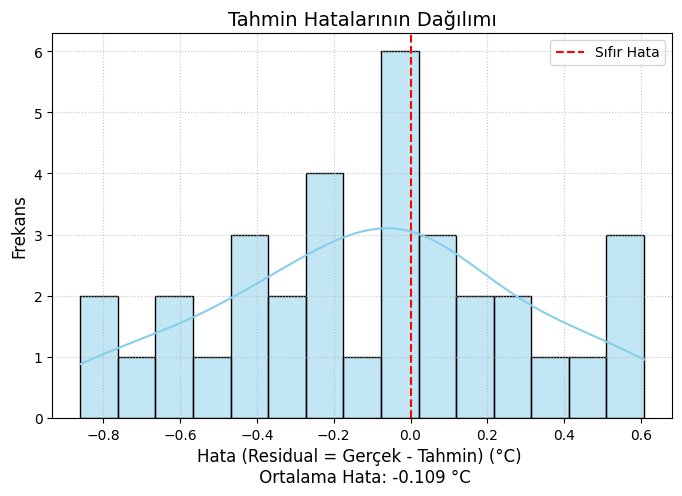

In [ ]:
def visualize_results(y_test, y_pred):
    """Gerçek değerler ve tahmin edilen değerleri karşılaştıran bir dağılım grafiği çizer."""

    # Gerçek ve Tahmin edilen değerleri tek bir DataFrame'de toplayalım
    results_df = pd.DataFrame({'Gerçek Sıcaklık': y_test, 'Tahmin Edilen': y_pred})

    # 1. Dağılım Grafiği (Scatter Plot)
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x='Gerçek Sıcaklık', y='Tahmin Edilen', data=results_df)

    # Mükemmel tahmin doğrusunu (y=x) çizelim
    # Limitleri belirleyelim
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())

    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Mükemmel Tahmin ($y=x$)')

    plt.title('Görünür Sıcaklık Tahmini: Gerçek vs. Tahmin Edilen Değerler', fontsize=14)
    plt.xlabel('Gerçek Görünür Sıcaklık (°C)', fontsize=12)
    plt.ylabel('Tahmin Edilen Görünür Sıcaklık (°C)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()

    # 2. Hata Dağılımı Grafiği (Residual Plot)
    # Hata (Residual) = Gerçek Değer - Tahmin Edilen Değer
    errors = y_test - y_pred

    plt.figure(figsize=(8, 5))
    sns.histplot(errors, kde=True, bins=15, color='skyblue')

    plt.title('Tahmin Hatalarının Dağılımı', fontsize=14)
    plt.xlabel(f'Hata (Residual = Gerçek - Tahmin) (°C) \n Ortalama Hata: {errors.mean():.3f} °C', fontsize=12)
    plt.ylabel('Frekans', fontsize=12)
    plt.axvline(0, color='red', linestyle='--', label='Sıfır Hata')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()

if 'y_test' in locals() and 'y_pred' in locals():
    visualize_results(y_test, y_pred)
else:
    print("Hata: y_test veya y_pred değişkenleri bulunamadı. Lütfen önceki model eğitim kodunu tekrar çalıştırın.")